In [2]:
import nltk
import random
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews as mr
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/taya/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Mirar como es el fichero:

In [3]:
print(len(mr.fileids()) )#hay 2000 ficheros (1000 exemples positius i 1000 negatius)
print(mr.words('pos/cv000_29590.txt'))
print(mr.categories())
print(mr.fileids('pos')) #lista todos los ficheros positivos
print((list(mr.words('pos/cv000_29590.txt')), 'pos') )

2000
['films', 'adapted', 'from', 'comic', 'books', 'have', ...]
['neg', 'pos']
['pos/cv000_29590.txt', 'pos/cv001_18431.txt', 'pos/cv002_15918.txt', 'pos/cv003_11664.txt', 'pos/cv004_11636.txt', 'pos/cv005_29443.txt', 'pos/cv006_15448.txt', 'pos/cv007_4968.txt', 'pos/cv008_29435.txt', 'pos/cv009_29592.txt', 'pos/cv010_29198.txt', 'pos/cv011_12166.txt', 'pos/cv012_29576.txt', 'pos/cv013_10159.txt', 'pos/cv014_13924.txt', 'pos/cv015_29439.txt', 'pos/cv016_4659.txt', 'pos/cv017_22464.txt', 'pos/cv018_20137.txt', 'pos/cv019_14482.txt', 'pos/cv020_8825.txt', 'pos/cv021_15838.txt', 'pos/cv022_12864.txt', 'pos/cv023_12672.txt', 'pos/cv024_6778.txt', 'pos/cv025_3108.txt', 'pos/cv026_29325.txt', 'pos/cv027_25219.txt', 'pos/cv028_26746.txt', 'pos/cv029_18643.txt', 'pos/cv030_21593.txt', 'pos/cv031_18452.txt', 'pos/cv032_22550.txt', 'pos/cv033_24444.txt', 'pos/cv034_29647.txt', 'pos/cv035_3954.txt', 'pos/cv036_16831.txt', 'pos/cv037_18510.txt', 'pos/cv038_9749.txt', 'pos/cv039_6170.txt', 'pos/cv

# Particion Train y Test:

In [4]:
doc_pos = [mr.words(f) for f in mr.fileids('pos')]
doc_neg = [mr.words(f) for f in mr.fileids('neg')]

In [5]:
random.shuffle(doc_pos)
random.shuffle(doc_neg)

In [6]:
train_pos = doc_pos[:int((len(doc_pos)*0.7))] #70% para el train
test_pos = doc_pos[int((len(doc_pos)*0.7)):] #30% final para el test

train_neg = doc_neg[:int((len(doc_neg)*0.7))]
test_neg = doc_neg[int((len(doc_neg)*0.7)):]

In [7]:
train = train_pos + train_neg
test = test_pos + test_neg
#hay que guardar estos ficheros porque cada vez que ejecutemos el codigo el random va a cambiar el contenido

In [8]:
print(len(train_pos), len(train_neg))
print(len(test_pos), len(test_neg))

700 700
300 300


In [9]:
train[699] in train_pos

True

In [10]:
train_labels = ['pos']*700 + ['neg']*700
print(len(train_labels))
test_labels = ['pos']*300 + ['neg']*300

1400


# Preprocesamiento

In [11]:
import re

def preproces(text):
    text_clean = []
    # Expresión regular para eliminar todo lo que no sea una letra o un espacio
    regex = r"[^a-zA-Z\s]"
    
    # Diccionario de reemplazo
    replacements = {
        "t": "not",
        's': 'is', #aunque tambien puede ser posesivo
        "didn": "did",
        "haven": "have",
        "hasn": "has",
        "hadn": "had",
        "shouldn": "should",
        "wouldn": "would",
        "couldn": "could",
        "mustn": "must",
        'doesn': 'does',
        'isn' : 'is',
        'aren' : 'are',
        'll': 'will',
        've' : 'have', 
        'd' : 'would',
        'm': 'am'
    }
    
    for w in text:
        # Eliminar caracteres no deseados y números
        limpio = re.sub(regex, "", w)
        # Convertir a minúsculas
        limpio = limpio.lower()
        # Eliminar espacios en blanco al principio y al final
        limpio = limpio.strip()
        # Eliminar si la palabra es "s"
        #if limpio == "s":
           # continue
        # Reemplazar si está en el diccionario
        if limpio in replacements:
            limpio = replacements[limpio]
        # Filtrar tokens vacíos
        if limpio != "":
            text_clean.append(limpio)
    
    return text_clean

In [12]:
clean_train = [preproces(words) for words in train]
print(clean_train[0])
clean_test = [preproces(words)for words in test]

['sometimes', 'i', 'find', 'th', 'century', 'british', 'costume', 'dramas', 'a', 'little', 'hard', 'to', 'relate', 'to', 'it', 'is', 'not', 'the', 'time', 'or', 'the', 'distance', 'it', 'is', 'the', 'rules', 'and', 'conventions', 'of', 'a', 'social', 'class', 'that', 'deserves', 'resentment', 'rather', 'than', 'sympathy', 'yet', 'somehow', 'the', 'movies', 'are', 'all', 'well', 'made', 'and', 'i', 'always', 'get', 'caught', 'up', 'in', 'the', 'story', 'the', 'wings', 'of', 'the', 'dove', 'fits', 'the', 'pattern', 'kate', 'helena', 'bonham', 'carter', 'and', 'merton', 'linus', 'roache', 'are', 'in', 'love', 'merton', 'a', 'newspaper', 'writer', 'would', 'like', 'to', 'marry', 'kate', 'but', 'kate', 'is', 'job', 'if', 'you', 'will', 'is', 'to', 'be', 'a', 'member', 'of', 'the', 'british', 'upper', 'class', 'her', 'father', 'lost', 'all', 'of', 'her', 'family', 'is', 'money', 'but', 'a', 'wealthy', 'aunt', 'agreed', 'to', 'take', 'care', 'of', 'her', 'until', 'she', 'married', 'a', 'nice'

# Lematizacion

In [13]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/taya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [14]:
#Poner tags y no incluir stop Words ya que no aportaran informacion importante para el Sentiment Analisys
train_tagged = []
tags = set()
stop_tags = {'DT', 'IN', 'CC', 'PRP', 'PRP$', 'WP', 'WP$', 'RP', 'TO', 'CD', 'EX', 'WDT'}
for l in clean_train:
    aux = []
    con_tag = nltk.pos_tag(l)
    for w, tag in con_tag:
        if tag not in stop_tags:
            aux.append((w, tag))
            tags.add(tag)
    train_tagged.append(aux)

In [15]:
print(tags) #todos los tags unicos que aparecen en el train

{'NNP', 'VBZ', 'RB', 'VBD', 'POS', 'RBR', 'NN', 'SYM', 'JJ', 'PDT', 'NNS', 'VBP', 'JJS', 'WRB', 'VB', 'RBS', 'UH', 'NNPS', 'JJR', '$', 'FW', 'VBN', 'MD', 'VBG'}


In [16]:
#ejemplo del resultado
print(train_tagged[0])
print(train[0]) 

[('sometimes', 'RB'), ('i', 'JJ'), ('find', 'VBP'), ('th', 'JJ'), ('century', 'NN'), ('british', 'JJ'), ('costume', 'NN'), ('dramas', 'VBD'), ('little', 'JJ'), ('hard', 'JJ'), ('relate', 'VB'), ('is', 'VBZ'), ('not', 'RB'), ('time', 'NN'), ('distance', 'NN'), ('is', 'VBZ'), ('rules', 'NNS'), ('conventions', 'NNS'), ('social', 'JJ'), ('class', 'NN'), ('deserves', 'VBZ'), ('resentment', 'NN'), ('rather', 'RB'), ('sympathy', 'VB'), ('yet', 'RB'), ('somehow', 'VBP'), ('movies', 'NNS'), ('are', 'VBP'), ('well', 'RB'), ('made', 'VBN'), ('i', 'VB'), ('always', 'RB'), ('get', 'VB'), ('caught', 'VBN'), ('story', 'NN'), ('wings', 'NNS'), ('dove', 'NN'), ('fits', 'VBZ'), ('pattern', 'NN'), ('kate', 'VB'), ('helena', 'NN'), ('bonham', 'NN'), ('carter', 'NN'), ('merton', 'NN'), ('linus', 'NN'), ('roache', 'NN'), ('are', 'VBP'), ('love', 'JJ'), ('merton', 'NN'), ('newspaper', 'NN'), ('writer', 'NN'), ('would', 'MD'), ('like', 'VB'), ('marry', 'VB'), ('kate', 'VB'), ('kate', 'VB'), ('is', 'VBZ'), ('j

In [17]:
#ver otros ejemplos de palabras con un cierto tag
palabras = []
for l in train_tagged:
    for palabra, etiqueta in l:
            if etiqueta == '$':
                palabras.append(palabra)
print(palabras)

['ten']


El tag '$' es un error del tagger pero no upondrá ningún problema. Además, al observar el tag "FW" (palabras que se etiquetan como extranjeras) vemos que podríamos eliminar errores, palabras en otros idiomas, nombres propios, pero también palabras normales. Como posteriormnte se va a hacer filtrado de frequencias esperamos que se eliminarán las palabras no deseadas y quedarán las que sí que tienen sentido.

Se lematizan solo estas categorias, reconocidas por SentiWordNet:

Sustantivos ('n')	'NN', 'NNS', 'NNP', 'NNPS'
Verbos ('v')	'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
Adjetivos ('a')	'JJ', 'JJR', 'JJS'
Adverbios ('r')	'RB', 'RBR', 'RBS'

In [18]:
nltk.download('wordnet')
nltk.download('omw-1.4')
wnl = nltk.stem.WordNetLemmatizer()
def lemmatize(p):
  d = {'NN': 'n', 'NNS': 'n', 'NNP' : 'n', 'NNPS':'n',
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a', 
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 'MD':'v',
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'} 
  if p[1] in d:
    return wnl.lemmatize(p[0], pos=d[p[1]])
  return p[0]

[nltk_data] Downloading package wordnet to /home/taya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/taya/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [19]:
train_lemat = []
for l in train_tagged:
    aux = []
    for i in l:
        aux.append(lemmatize(i))
    train_lemat.append(aux)

## Vectroización BoW

In [20]:
vectorizer = CountVectorizer()
train_aplanado = [' '.join(sublista) for sublista in train_lemat]
X_train = vectorizer.fit_transform(train_aplanado)

In [21]:
X_train.shape

(1400, 27461)

Eliminacion de frequencias bajas

In [22]:
# Sumamos las frecuencias de cada palabra en todos los documentos
word_frequencies = X_train.sum(axis=0).A1
# Obtenemos el vocabulario mapeado a índices
words = vectorizer.get_feature_names_out()
# Convertimos en un diccionario {palabra: frecuencia}
freq_dict = dict(zip(words, word_frequencies))
# Ordenamos por frecuencia ascendente
sorted_freq = sorted(freq_dict.items(), key=lambda x: x[1])
print(sorted_freq[:10])  # Muestra las 10 palabras menos frecuentes


[('aa', np.int64(1)), ('aaa', np.int64(1)), ('aaaahhhs', np.int64(1)), ('aahs', np.int64(1)), ('aamir', np.int64(1)), ('aatish', np.int64(1)), ('abate', np.int64(1)), ('abberation', np.int64(1)), ('abbots', np.int64(1)), ('abbott', np.int64(1))]


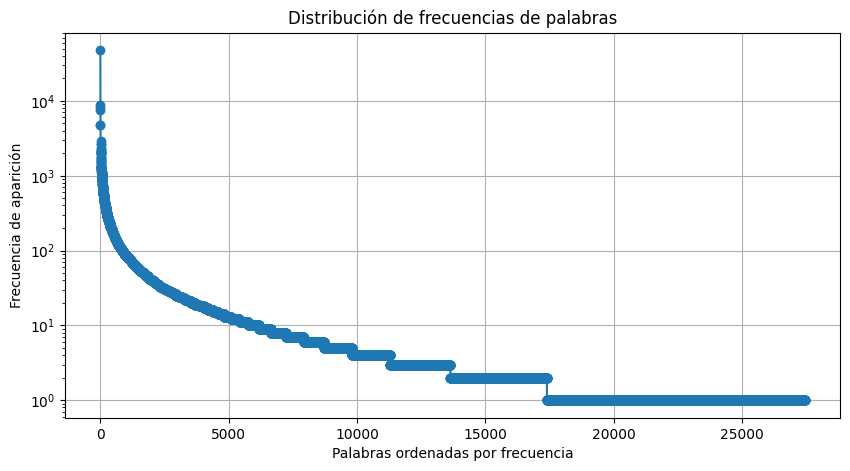

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Ordenamos las frecuencias en orden descendente
sorted_freq_values = np.array(sorted(word_frequencies, reverse=True))

# Creamos la gráfica
plt.figure(figsize=(10,5))
plt.plot(sorted_freq_values, marker="o", linestyle="-")

# Agregamos etiquetas
plt.xlabel("Palabras ordenadas por frecuencia")
plt.ylabel("Frecuencia de aparición")
plt.title("Distribución de frecuencias de palabras")
plt.yscale("log") 
plt.grid()

In [24]:
min_freq = 3  # Umbral mínimo (si se pone mas agrande se eliminaran mas de la mitad de las observaciones)
vectorizer = CountVectorizer(min_df=min_freq)
X_filtered = vectorizer.fit_transform(train_aplanado)

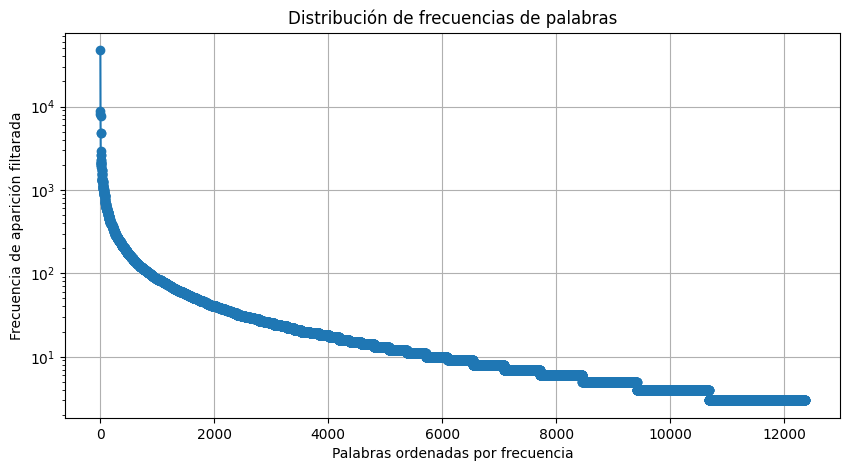

In [25]:
word_frequencies = X_filtered.sum(axis=0).A1
sorted_freq_values = np.array(sorted(word_frequencies, reverse=True))

# Creamos la gráfica
plt.figure(figsize=(10,5))
plt.plot(sorted_freq_values, marker="o", linestyle="-")

# Agregamos etiquetas
plt.xlabel("Palabras ordenadas por frecuencia")
plt.ylabel("Frecuencia de aparición filtarada")
plt.title("Distribución de frecuencias de palabras")
plt.yscale("log") 
plt.grid()

In [26]:
X_filtered.shape #train final

(1400, 12365)

# Modelos supervisados. Parte 1:

# Modelos no supervisados. Parte 2:

In [41]:
from collections import Counter
#filtar Train_lemat
# Calcular la frecuencia de todas las palabras en train_lemat
word_freq = Counter()
for doc in train_lemat:
    word_freq.update(doc)

min_freq = 5

filtered_words = {word for word, freq in word_freq.items() if freq < min_freq}
filtered_train_lemat = [
    [word for word in doc if word not in filtered_words]
    for doc in train_lemat]

In [28]:
filtered_words2 = {word for word, freq in word_freq.items() if freq >= min_freq}

In [29]:
print(len(filtered_words))
print(len(filtered_words2))

16166
11319


In [30]:
from textserver import TextServer 

In [ ]:
ts = TextServer('taisiia.prymak', '', 'senses') 

In [32]:
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/taya/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /home/taya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/taya/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [33]:
result = ts.senses('lively')[0][0]
print(result)

HTTPError: 401 Client Error:  for url: http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/senses

In [33]:
print(lesk(train_lemat[8], 'lively'))
 #hay palabras que Freeling es incapaz de encpntrar su synset, pero lesk si

Synset('lively.a.01')


In [34]:
p = lesk(train_lemat[8], 'devine')
p is None

True

In [38]:
def get_synsets(w, contexto):
    try:
        result = ts.senses(w)[0][0]
        categ = result[4][-1]
        id = int(result[4][0:8])
        synset1 = wn.synset_from_pos_and_offset(categ, id)
        print("From Freeling!")
        return synset1
    except:
        return lesk(contexto, w) 

In [43]:
len(filtered_train_lemat[1])

352

In [42]:
prueba = [filtered_train_lemat[0]]

Metodo simple:
Clasificaci´on de polaridad:
score(s) = poss − neg

In [44]:
etiquetas_predichas = []
for l in prueba:
    pos_s = 0
    neg_s = 0
    for w in l:
        print(w)
        s1 = get_synsets(w, l) 
        print(s1)
        print()
        if s1 is not None:
            senti_synset = swn.senti_synset(s1.name())
            pos_s =+ senti_synset.pos_score()
            neg_s =+ senti_synset.neg_score()
            print('pos_s', pos_s)
            print('neg_s', neg_s)
        #else: si el sinset NO esta en sentiWordNet se va a suponer que su puntuacion es 0 JUSTIFICAR 
    if pos_s - neg_s >=0: #si es neutral clasificar como positivo?????????????????????????????????????????????????????????????????????
        print("pos")
        etiquetas_predichas.append("pos")
    else:
        print('neg')
        etiquetas_predichas.append("neg")
    

sometimes
Synset('sometimes.r.01')

pos_s 0.0
neg_s 0.0
i
Synset('one.s.01')

pos_s 0.0
neg_s 0.25
find
Synset('find_oneself.v.01')

pos_s 0.0
neg_s 0.0
th
Synset('thursday.n.01')

pos_s 0.0
neg_s 0.0
century
Synset('hundred.n.01')

pos_s 0.0
neg_s 0.0
british
Synset('british.n.01')

pos_s 0.0
neg_s 0.0
costume
Synset('costume.n.04')

pos_s 0.0
neg_s 0.0
little
Synset('little.a.02')

pos_s 0.0
neg_s 0.375
hard
Synset('hard.r.08')

pos_s 0.0
neg_s 0.0
relate
Synset('relate.v.05')

pos_s 0.0
neg_s 0.0
be
Synset('be.v.02')

pos_s 0.0
neg_s 0.0
not
Synset('not.r.01')

pos_s 0.0
neg_s 0.625
time
Synset('time.v.05')

pos_s 0.0
neg_s 0.0
distance
Synset('outdistance.v.01')

pos_s 0.0
neg_s 0.0
be
Synset('be.v.02')

pos_s 0.0
neg_s 0.0
rule
Synset('rule.v.04')

pos_s 0.0
neg_s 0.0
convention
Synset('convention.n.05')

pos_s 0.0
neg_s 0.0
social
Synset('social.s.05')

pos_s 0.0
neg_s 0.0
class
Synset('class.n.06')

pos_s 0.0
neg_s 0.0
deserve
Synset('deserve.v.01')

pos_s 0.75
neg_s 0.125
resen

In [40]:
etiquetas_predichas

['pos']